In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

## load path
import os
import sys
sys.path.append('../')
sys.path.append('../models')
from pathlib import Path

## load utils 
from util.util import *
from util.true_gaussian_process_seq import *
from util.ofm_OT_likelihood_seq_mino import *
from util.metrics import *
import time

## load modules 
from models.mino_transformer import MINO
from models.mino_modules.decoder_perceiver import DecoderPerceiver
from models.mino_modules.encoder_supernodes_gno_cross_attention import EncoderSupernodes
from models.mino_modules.conditioner_timestep import ConditionerTimestep

In [2]:
x_dim = 3

device = 'cuda:5' if torch.cuda.is_available() else 'cpu'
spath = Path('./saved_models/MINO_T_Climate')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# GP hyperparameters
kernel_length = 0.05
kernel_variance=1
nu = 0.5 # default


# model hyperparameters
dim = 256
num_heads=4


## training parameters
epochs = 480
sigma_min=1e-4
batch_size = 48

In [3]:
# follow the tutorails of GeometricKernel Library (Mostowsky et al, 2024)
_NUM_LONGS = 90
_NUM_LATS = 46 

############
# generate a grid on the sphere
longs, lats =  np.mgrid[0:2*np.pi:(_NUM_LONGS+1)*1j, 0:np.pi:_NUM_LATS*1j]

longs, lats = longs[:-1,:], lats[:-1,:]

other_points_xs = np.sin(lats) * np.cos(longs)
other_points_ys = np.sin(lats) * np.sin(longs)
other_points_zs = np.cos(lats)

other_points = np.c_[np.ravel(other_points_xs),
                     np.ravel(other_points_ys),
                     np.ravel(other_points_zs)]

n_pos = other_points


In [4]:
def latent_query_sphere(num_longs, num_lats):
    longs, lats =  np.mgrid[0:2*np.pi:(num_longs+1)*1j, 0:np.pi:num_lats*1j]

    longs, lats = longs[:-1,2:-2], lats[:-1,2:-2] # remove queried nodes in (near) the poles

    print("longs:{}".format(longs.shape))
    other_points_xs = np.sin(lats) * np.cos(longs)
    other_points_ys = np.sin(lats) * np.sin(longs)
    other_points_zs = np.cos(lats)

    query_pos = np.c_[np.ravel(other_points_xs),
                         np.ravel(other_points_ys),
                         np.ravel(other_points_zs)]
    
    return query_pos

In [12]:
#query_pos = latent_query_sphere(num_longs=48, num_lats=28) #(32, 16) #->21144
query_pos_input = latent_query_sphere(num_longs=32, num_lats=20)

longs:(32, 16)


In [13]:
from mpl_toolkits.mplot3d import Axes3D   # registers 3‑D projection

In [14]:
def plot_3d_scatter(pos, s=1):
    x, y, z = pos.T
    
    fig = plt.figure(figsize=(6, 5))
    ax  = fig.add_subplot(111, projection="3d")

    ax.scatter(x, y, z,
               s=s,            # marker size
               alpha=0.8)       # slight transparency

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3‑D scatter plot")

    plt.tight_layout()
    plt.show()    

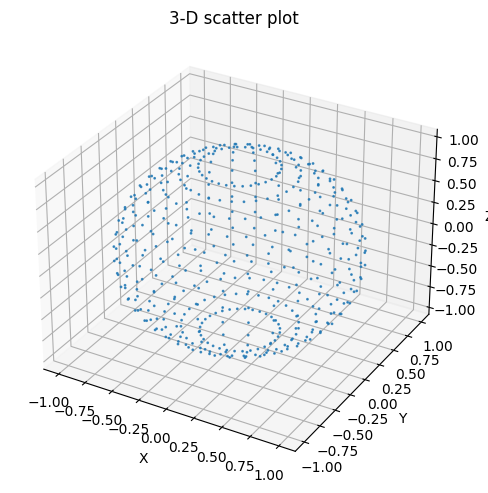

In [16]:
plot_3d_scatter(query_pos_input)

In [18]:
x_train = np.load('../dataset/weather/train_climate.npy')
x_train = torch.Tensor(x_train[:,2:3]).permute(0,1,3,2) # 0:2 (longitude, latitude)
x_train = torch.flatten(x_train, start_dim=2)


n_pos = torch.Tensor(n_pos)
pos_data = n_pos.unsqueeze(0).repeat(len(x_train), 1, 1).permute(0, 2, 1)

query_pos_input = torch.Tensor(query_pos_input).permute(1,0)
train_dataset = SimDataset(x_train, pos_data, query_pos_input)

loader_tr =  DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=SimulationCollator,
)

## Model Initialization

In [19]:
#model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=x_dim, t_scaling=1).to(device)
# initialize model
conditioner = ConditionerTimestep(
    dim=dim
)
model = MINO(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        input_dim=1,
        ndim=3,
        radius = 0.2,
        enc_dim=dim,
        enc_num_heads=num_heads,
        enc_depth=5,
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        input_dim=dim,
        output_dim=1,
        ndim=3,
        dim=dim,
        num_heads=num_heads,
        depth=2,
        unbatch_mode="dense_to_sparse_unpadded",
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

parameters: 21.5M


In [13]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)


In [ ]:
fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(480), generate=False, save_path=spath,saved_model=saved_model)

## Evaluation

In [20]:
for param in model.parameters():
    param.requires_grad = False


model_path = os.path.join(spath, 'epoch_480.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint, strict=False)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)


In [21]:
## given the batch_size def pos, super_idxs, batch_idx

In [27]:
def gen_meta_info(batch_size, query_pos, n_pos):
    # return pos, super_idxs, batch_idx need for 
    # pos : [batch_size, n_chan, n_seq]
    # super_idxs : [batch_size*n_super_nodes]
    # batch_idxs : [batch_size*n_seq]
    
    #n_pos = make_2d_grid(dims)  
    n_pos = n_pos
    pos_data = n_pos.unsqueeze(0).repeat(batch_size, 1, 1)
    
    #query_pos = make_3d_grid(query_dims, x_min=-1, x_max=1)
    query_pos_data = query_pos.unsqueeze(0).repeat(batch_size, 1, 1)

    collated_batch = {}


    collated_batch["input_pos"] = pos_data.permute(0, 2, 1)
    collated_batch['query_pos']= query_pos_data


    
    return collated_batch

In [ ]:
import time
start = time.time()

with torch.no_grad():

    X_alt = []
    for i in range(26):
        collated_batch =  gen_meta_info(batch_size=100, n_pos=n_pos, query_pos=query_pos_input)
        pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
        X_temp = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=100, n_channels=1, n_eval=5).cpu()
    
        #X_temp = fmot.sample(pos=pos_data[:200].to(device), n_samples=200, n_eval=10).cpu()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt).squeeze()
    
end = time.time()
print(end-start)

## Metrics

In [23]:
x_test =  np.load('../dataset/weather/test_climate.npy')

x_test = torch.Tensor(x_test[:,2:3]).permute(0,1,3,2) # (longitude, latitude)
x_test = torch.flatten(x_test, start_dim=2)


In [25]:
swd_value = swd_stable(X=X_alt, Y=x_test)

In [27]:
mmd_value = unbiased_mmd2_torch(X=X_alt, Y=x_test, device=device)  

## Visualization

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

def globe_plot(latitude, longitude, temperature, view=(100., 0.), flat=False,
               vmin=None, vmax=None, cmap='plasma', smooth_factor=1.0,
               save_fig=''):
    """Plots temperature on a globe.

    Args:
        latitude (array-like): Array of shape (m,) containing latitude values.
        longitude (array-like): Array of shape (n,) containing longitude values.
        temperature (array-like): Array of shape (m, n) containing temperatures.
        view (tuple of floats): Longitude and latitude values for the view of
            the globe.
        flat (bool): If True, creates flat map plot, otherwise plots globe.
        smooth_factor (float): If not 1, smooths the data by sampling it
            smooth_factor times more finely and interpolating.
        save_fig (string): If non-empty, saves image at location given by
            save_fig.
    """
    # Set map projection
    if flat:
        ax = plt.axes(projection=ccrs.PlateCarree())
    else:
        ax = plt.axes(projection=ccrs.Orthographic(*view))

    # Add coastlines
    ax.coastlines()

    # Plot climate data
    if smooth_factor == 1.0:
        mesh = ax.pcolormesh(longitude, latitude, temperature,
                             transform=ccrs.PlateCarree(), cmap=cmap)
    else:
        #interp_func = interp2d(longitude, latitude, temperature, kind='cubic')
        interp_func = RectBivariateSpline(longitude, -latitude, temperature)
        num_lons = int(smooth_factor * len(longitude))
        lon_new = np.linspace(0, 360 - (360 / num_lons), num_lons)
        lat_new = np.linspace(latitude[0], latitude[-1], int(smooth_factor * len(latitude)))
        # Not really sure why we need the minus for latitude here, but it just seems to work...
        temp_new = inter_func(lon_new, lat_new)

        #temp_new = interp_func(lon_new, -lat_new)
        mesh = ax.pcolormesh(lon_new, -lat_new, temp_new, transform=ccrs.PlateCarree(),
                             cmap=cmap)

    if len(save_fig):
        plt.savefig(save_fig, format='pdf', dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()


def globe_plot_from_data_tensor(data, view=(100., 0.), flat=False, vmin=None,
                                vmax=None, cmap='plasma', smooth_factor=1.0,
                                save_fig=''):
    """Helper function to plot directly from data tensor.

    Args:
        data (torch.Tensor): Shape (3, num_lats, num_lons).
    """
    latitude = data[0, :, 0]
    longitude = data[1, 0, :]
    temperature = data[2]
    globe_plot(latitude, longitude, temperature, view, flat, vmin, vmax, cmap,
               smooth_factor, save_fig)

In [40]:
x_temp = np.load('/net/ghisallo/scratch1/yshi5/OFM/dataset/weather/train_climate.npy')
real_lat, real_lon = x_temp[0, 0, :,0], x_temp[0,1,0,:]

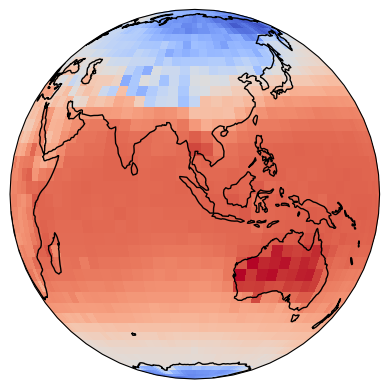

In [41]:
globe_plot(real_lat, real_lon, temp_result, view=(100., 0.), flat=False,
               vmin=None, vmax=None, cmap='coolwarm', smooth_factor=1.0,
               save_fig='')

In [42]:
def gen_sup_pos(_NUM_LONGS = 90, _NUM_LATS = 46):


    ############
    # generate a grid on the sphere
    longs, lats =  np.mgrid[0:2*np.pi:(_NUM_LONGS+1)*1j, 0:np.pi:_NUM_LATS*1j]

    longs, lats = longs[:-1,:], lats[:-1,:]

    other_points_xs = np.sin(lats) * np.cos(longs)
    other_points_ys = np.sin(lats) * np.sin(longs)
    other_points_zs = np.cos(lats)

    other_points = np.c_[np.ravel(other_points_xs),
                         np.ravel(other_points_ys),
                         np.ravel(other_points_zs)]

    n_pos = other_points
    return other_points_xs, other_points_ys, other_points_zs, n_pos

In [43]:
sup_other_points_xs, sup_other_points_ys, sup_other_points_zs, sup_pos = gen_sup_pos(_NUM_LONGS = 90*2, _NUM_LATS = 46*2)

In [44]:
with torch.no_grad():

    collated_batch =  gen_meta_info(batch_size=10,   query_pos=query_pos_input, n_pos=torch.Tensor(sup_pos))
    pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
    X_hat = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=10).cpu()
    #X_hat = X_hat.reshape(X_hat.shape[0], *dims)

In [50]:
sup_lat = np.linspace(90, -90, 2*len(real_lat))
sup_lon = np.linspace(0, 360, 2*len(real_lon)+1)[:-1]

In [48]:
sample_sup = X_hat[0].reshape(_NUM_LONGS*2, _NUM_LATS*2).transpose(1,0)

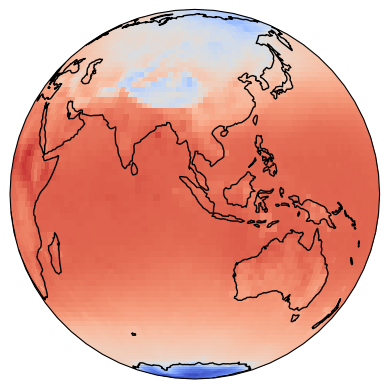

In [51]:

globe_plot(sup_lat, sup_lon, sample_sup, view=(100., 0.), flat=False,
               vmin=None, vmax=None, cmap='coolwarm', smooth_factor=1.0,
               save_fig='')
